# SETUP

The code cells below contains necessary imports, util functions, and global variables that are used throughout the noteboook

In [1]:
import os
import csv
import ast
import json
import pickle
import itertools
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# util functions
import utils

# display floating points in pandas with 5 digits after decimal points
pd.options.display.float_format = '{:.5f}'.format

PROJECT_DIR = "./" # path to the project directory
DATA_DIR = os.path.join(PROJECT_DIR, "data/") # path to the data directory
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output/") # path to store outputs produced during training and evaluation.
DATASET_PATH = os.path.join(DATA_DIR, "Raw_data/") # path the raw data directory

# create the data and output dir if it does not exist yet.
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# miscallenous
EVALUATION_COLUMNS = ["accuracy", "recall_score", "precision_score", "f1_score", "tn", "fp", "fn", "tp"]

# Table of Content

1. [Answering the Question](#answering-the-question)

2. [Tidying the Data](#tidying-the-data)

3. [Checking the data](#checking-the-data)

4. [Exploratory Analysis](#exploratory-analysis)

5. [Data Preparation](#data-preparation)

6. [Statistical Modelling & Inference](#statistical-modelling)

7. [Results Analysis and Discussion](#results-analysis-and-discussion)
   
8. [Final Model Training](#final-model-training)

# 1. Answering the Question <a class="anchor" id="answering-the-question"></a>

The below code cells is my thought process for understanding the problem. The guiding questions are taken from: https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb

1. Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

We are trying to predict/classify if a person is stressed based on raw sensor values from a wearable watch.

2. Did you define the metric for success before beginning?

The company wants to minimise false negatives. Therefore, we can use F1-score as measurement of performance. In addition, we can also look at the Precision/Recall curves of model with highest mAP and then select a confidence threshold that maximises both the recall and precision of the model.

3. Did you understand the context for the question and the scientific or business application?

The aim is to add this classification pipeline as a new feature to a wearable watch that can alert users when they are stressed.


4. Did you record the experimental design?

The data was collected from 35 participants (students and staff of the University of Galway and the University Hospital Galway, Ireland). While wearing an Empatica E4 watch, each participant is asked to perform a series of stress inducing tasks followed by 4 rest periods. For each participant, the data recorded include:
- ACC.csv (accelerometer data (x, y, z axis))
- BVP.csv (raw BVP data)
- EDA.csv (EDA data (skin conductance))
- HR.csv (heart rate data)
- IBI.csv (inter-beat-interval data)
- info.txt (information about all the csv file and sampling rate)
- tags_SX.csv (timestamp tags. start-end time of each task)
- TEMP.csv (skin temperature data)

5. Did you consider whether the question could be answered with the available data?

The provided data does have timestamp of the start and end of each task. These values can be used to derived the class labels (stress vs non-stress) for every data samples. A sample is marked as stress if falls within a stress-inducing activity.

# 2. Tidying the Data <a class="anchor" id="tidying-the-data"></a>

The code cells in this sections aims to combine the measurements of all participants into 1 dataframe and save it into 1 csv file called `dataset.csv`

## 2.1. Combining measurements of 1 particpant

Since the data from each subject is grouped by folders (S01-S35), I aim to combine the recorded data of a participant into one single DataFrame.

For each participant, 6 measurements are stored in 6 different files: `ACC.csv`, `BVP.csv`, `EDA.csv`, `HR.csv`, `IBI.csv`, `TEMP.csv`. Each of these measurements has different sampling rate but the sampling rate of a measurement is the same across all participants. In addition, `tag_SX.csv` is also provided for determining the `start_time` and `end_time` of events performed by the participant. The first 3 events are the stress inducing events.



In [2]:
t = {}

participant = "S17"

for measure in glob(os.path.join(DATASET_PATH, participant, "*.csv")):
    m = measure.split(os.sep)[-1]
    if m not in [f'tags_{participant}.csv', 'IBI.csv']:
        df = pd.read_csv(measure, header=None)
        t[m] = { "sampling_rate":  int(df.iloc[1, 0]) }

t["IBI.csv"] = { "sampling_rate":  64 } # the same as BVP because it is calculated from BVP measurement

pd.DataFrame(t)

,TEMP.csv,HR.csv,ACC.csv,EDA.csv,BVP.csv,IBI.csv
sampling_rate,4,1,32,4,64,64


Another thing to point out is that, the `starting_time` and `end_time` varies between some of the measurements.

In [3]:
t = []

participant = os.path.join(DATASET_PATH, "S17")

for measurement in ["ACC.csv", "TEMP.csv", "HR.csv", "BVP.csv", "EDA.csv"]:
    _, start_time, end_time, _ = utils.read_raw_measurement_file(os.path.join(participant, measurement))
    
    t.append({
        "measurement": measurement,
        "start_time": start_time,
        "end_time": end_time
    })

# IBI.csv
_, start_time, end_time = utils.read_ibi_measurement_file(os.path.join(participant, "IBI.csv"))

t.append({
    "measurement": "IBI.csv",
    "start_time": start_time,
    "end_time": end_time
})

pd.DataFrame(t)

,measurement,start_time,end_time
0,ACC.csv,1645456369.00000,1645459680.00000
1,TEMP.csv,1645456369.00000,1645459679.00000
2,HR.csv,1645456379.00000,1645459681.00000
3,BVP.csv,1645456369.00000,1645459680.00000
4,EDA.csv,1645456369.00000,1645459678.00000
5,IBI.csv,1645456369.00000,1645459623.59375


To combine all of these measurements together into one dataframe representing a participant, some adjustments needs is needed:

1. Have consistent `start_time` and `end_time` across all measurements.
2. Have consistent `sampling_rate` across all measurements.

Therefore, I adopted the below approach:

1. The `start_time` is set to the latest start time across all measurements.
2. The `end_time` is set to the earliest end time across all measurements.
3. The `sampling_rate` is set to the highest `64` in order to retain all information.

In [4]:
df, start_time, end_time = utils.combine_participant_measurements(os.path.join(DATASET_PATH, "S17"), sampling_rate=64)
df.head()

,timestamp,accel_x,accel_y,accel_z,skin_temp,heart_rate,blood_volume_pulse,eda,inter_beat_interval
0,1645456379.00000,-39.00000,1.00000,51.00000,31.75000,83.00000,-45.11000,0.15248,NaN
1,1645456379.01562,-39.00000,1.00000,51.00000,31.75000,83.00000,-41.39000,0.15248,NaN
2,1645456379.03125,-40.00000,1.00000,50.00000,31.75000,83.00000,-36.03000,0.15248,NaN
3,1645456379.04688,-40.00000,1.00000,50.00000,31.75000,83.00000,-30.45000,0.15248,NaN
4,1645456379.06250,-39.00000,1.00000,51.00000,31.75000,83.00000,-25.94000,0.15248,NaN


To determine if each entry happens in a stress or non stress environment, I used the below steps:

1. Determine the `start_time` and `end_time` of each stress inducing tasks.
2. If an entry timestamp falls within one of those stress inducing event then it is marked as stress.

In [5]:
df, start_time, end_time = utils.read_participant_measurements(os.path.join(DATASET_PATH, "S17"), sampling_rate=64)
df.head()

,timestamp,accel_x,accel_y,accel_z,skin_temp,heart_rate,blood_volume_pulse,eda,inter_beat_interval,stress
0,1645456379.00000,-39.00000,1.00000,51.00000,31.75000,83.00000,-45.11000,0.15248,NaN,False
1,1645456379.01562,-39.00000,1.00000,51.00000,31.75000,83.00000,-41.39000,0.15248,NaN,False
2,1645456379.03125,-40.00000,1.00000,50.00000,31.75000,83.00000,-36.03000,0.15248,NaN,False
3,1645456379.04688,-40.00000,1.00000,50.00000,31.75000,83.00000,-30.45000,0.15248,NaN,False
4,1645456379.06250,-39.00000,1.00000,51.00000,31.75000,83.00000,-25.94000,0.15248,NaN,False


## 2.2. Combining All Participants Data

After combining all the measurements for 1 participant, I can move on to combine all measurements from all 35 participants together.

In [6]:
dataframes = []

for participant in tqdm(sorted(list(glob(os.path.join(DATASET_PATH, "S*"))))):
    df, _, _ = utils.read_participant_measurements(participant, sampling_rate=64)
    df['participant'] = participant.split(os.sep)[-1]
    dataframes.append(df)

result = pd.concat(dataframes)

# re order columns so that the first two columns are: participant and timestamp
leading_columns = ['participant', 'timestamp']
reordered_columns = leading_columns + [col for col in result.columns.tolist() if col not in leading_columns]

# save the tidy dataset
result[reordered_columns].to_csv(os.path.join(DATA_DIR, "data.csv"), index=False, na_rep='NA')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [02:05<00:00,  3.59s/it]


My final tidy data consists of `11` features.

- `participant`: str
  The id of the participant.
- `timestamp`: float, seconds
  The UNIX format timestamp of the entry.
- `accel_x`: float, gravitational force g
  The x value of the accelerometer. 
- `accel_y`: float, gravitational force g
  The y value of the accelerometer.
- `accel_z`: float, gravitational force g
  The z value of the accelerometer.
- `skin_temp`: float, Celsius
  The skin temperature.
- `heart_rate`: float
  The average heart rate calculated from raw BVP value.
- `blood_volume_pulse`: float, nanowatts
  The raw BVP data.
- `eda`: float
  The skin conductance.
- `inter_beat_interval`: float, seconds
  The IBI values.
- `stress`: bool
  Is the timestamp during when a participant is performing stress inducing tasks.

# 3. Checking the data <a class="anchor" id="checking-the-data"></a>

The code cell in this sections deals with the missing values in the `inter_beat_interval` column and output the clean dataset into `clean_data.csv`.

In [7]:
dataset = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), na_values='NA')

In [8]:
dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7123136 entries, 0 to 7123135
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   participant          7123136 non-null  object 
 1   timestamp            7123136 non-null  float64
 2   accel_x              7123136 non-null  float64
 3   accel_y              7123136 non-null  float64
 4   accel_z              7123136 non-null  float64
 5   skin_temp            7123136 non-null  float64
 6   heart_rate           7123136 non-null  float64
 7   blood_volume_pulse   7123136 non-null  float64
 8   eda                  7123136 non-null  float64
 9   inter_beat_interval  50248 non-null    float64
 10  stress               7123136 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 550.2+ MB


There are alot of missing values for feature `inter_beat_interval`. This is because they represent distances between heart beats. I fill these NaN values by:

1. For the first timestamps with NaN, fill in with first know `inter_beat_interval`.
2. For the last timestamps with Nan, fill in with last known `inter_beat_interval`.

In [9]:
dataset = dataset.fillna(method='bfill') # for the first timestamps with NaN, fill in with first known.
dataset = dataset.fillna(method='ffill') # for the last timestamps with Nan, fill in with last known.

In [10]:
dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7123136 entries, 0 to 7123135
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   participant          7123136 non-null  object 
 1   timestamp            7123136 non-null  float64
 2   accel_x              7123136 non-null  float64
 3   accel_y              7123136 non-null  float64
 4   accel_z              7123136 non-null  float64
 5   skin_temp            7123136 non-null  float64
 6   heart_rate           7123136 non-null  float64
 7   blood_volume_pulse   7123136 non-null  float64
 8   eda                  7123136 non-null  float64
 9   inter_beat_interval  7123136 non-null  float64
 10  stress               7123136 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 550.2+ MB


In [11]:
dataset.to_csv(os.path.join(DATA_DIR, "clean_data.csv"), index=False)

# 4. Exploratory Analysis <a class="anchor" id="exploratory-analysis"></a>

The code cells in this section aims to visualise the `clean_data.csv` to see if there are any notable patterns.

The measurement outputs from the smart watch is a timeseries. This means that the order of the data points matters. From this insight, analysis should be done on a per participant basis and in a time series manner.

In [2]:
dataset = pd.read_csv(os.path.join(DATA_DIR, "clean_data.csv"), na_values='NA')

## 4.1. Class Distribution (Stress vs Non-Stress)

Since the aim is to predict the `stress` target, I first look at the class distribution.

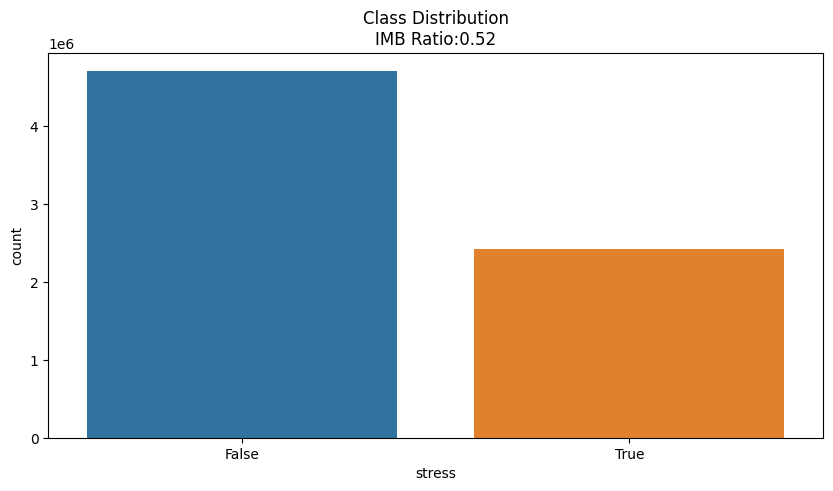

In [13]:
temp = dataset.copy()

fig = plt.figure(figsize=(10, 5))

sns.countplot(data=temp, x='stress')
_ = plt.title(f"Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(temp)}")

There is an imbalance between the `False` and `True`. The imbalance ratio shows that the `False` has more than double the `True` class. This is because the duration that a participant spent performing the stress inducing tasks ($\approx 18mins/participant$) is only a small fraction of the total experiment time ($\approx 60mins/participant$).

Later modelling process will need to take into account this class imbalance.

## 4.2. Participants' Experiment Visualisation

To know if a feature does have an effect of on the target `stress`, I opted to investigate if their averages changes during a `stress` vs a `non-stress` period.

I start by looking at biological features `heart_rate`, `skin_temp`, `eda`, `blood_volume_pulse`, and `inter_beat_interval`.

30/35 participants show increased in heart_rate during stress inducing tasks.
22/35 participants show increased in skin_temp during stress inducing tasks.
30/35 participants show increased in eda during stress inducing tasks.
15/35 participants show increased in blood_volume_pulse during stress inducing tasks.
7/35 participants show increased in inter_beat_interval during stress inducing tasks.


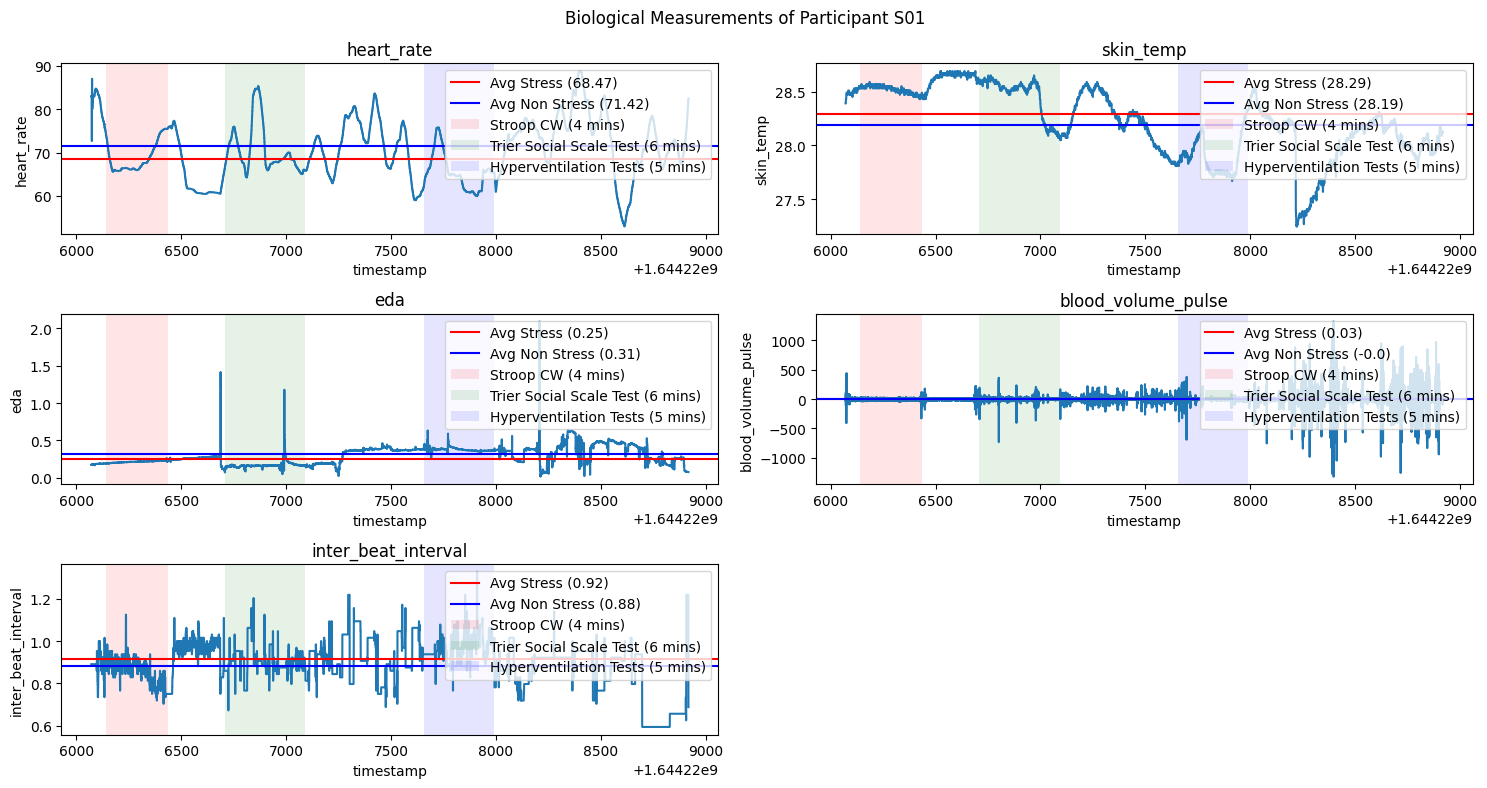

In [14]:
fig = plt.figure(figsize=(15, 8))
    
for idx, feature in enumerate(['heart_rate', 'skin_temp', 'eda', 'blood_volume_pulse', 'inter_beat_interval']):
    plt.subplot(3, 2, idx + 1)
    
    participant = 'S01'
    
    temp = dataset.copy()
    temp = temp[temp['participant'] == participant]
    
    plt.title(f"{feature}")
    utils.plot_experiment_measurement_as_timeseries(temp, feature)
    
    plt.suptitle(f"Biological Measurements of Participant {participant}")
    
    # calculate number of participant experiencing the same effect
    result = []
    
    participants = dataset['participant'].unique().tolist()
    
    for idx, participant in enumerate(participants):
        temp = dataset.copy()
        temp = temp[temp['participant'] == participant]

        avg_stress = temp[temp['stress'] == True][feature].mean()
        avg_non_stress = temp[temp['stress'] == False][feature].mean()
        
        result.append({"participant": participant, "stress": avg_stress, "non_stress": avg_non_stress})
    
    result = pd.DataFrame(result)

    result['temp'] = result['stress'] > result['non_stress']
    print(f"{result['temp'].sum()}/{len(participants)} participants show increased in {feature} during stress inducing tasks.")

fig.tight_layout(h_pad=1, w_pad=1)
plt.show()

The above shows that in majority of participants:

1. `heart_rate`, `skin_temp`, and `eda` increases during the stress inducing tasks.
2. `blood_volume_pulse` effects is not clear across participants.
3. `inter_beat_interval` decreases during stress inducing tasks.

Next, I visualise the `accel_x`, `accel_y`, and `accel_z` in a similar manner.

26/35 participants show increased in accel_x during stress inducing tasks.
18/35 participants show increased in accel_y during stress inducing tasks.
26/35 participants show increased in accel_z during stress inducing tasks.


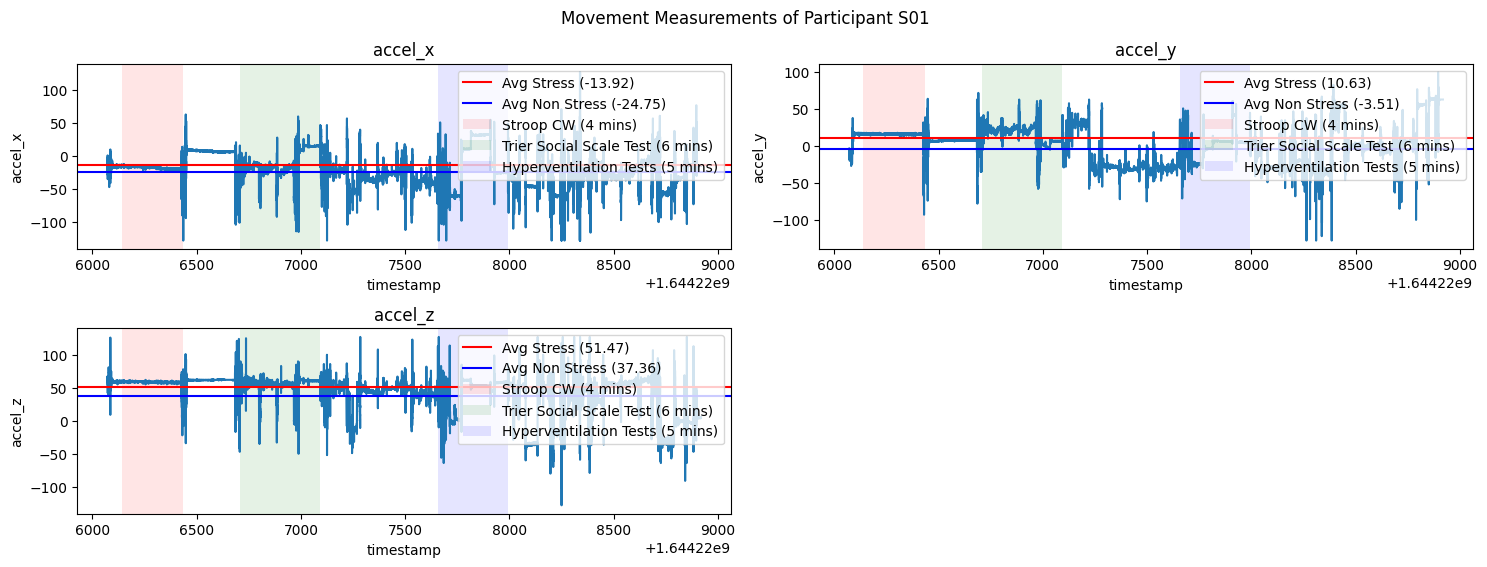

In [15]:
fig = plt.figure(figsize=(15, 8))

for idx, feature in enumerate(['accel_x', 'accel_y', 'accel_z']):
    plt.subplot(3, 2, idx + 1)

    participant = 'S01'
    temp = dataset.copy()
    temp = temp[temp['participant'] == participant]

    plt.title(f"{feature}")
    utils.plot_experiment_measurement_as_timeseries(temp, feature)

    plt.suptitle(f"Movement Measurements of Participant {participant}")

    # calculate number of participant experiencing the same effect
    result = []

    participants = dataset['participant'].unique().tolist()
    
    for idx, participant in enumerate(participants):
        temp = dataset.copy()
        temp = temp[temp['participant'] == participant]

        avg_stress = temp[temp['stress'] == True][feature].mean()
        avg_non_stress = temp[temp['stress'] == False][feature].mean()

        result.append({"participant": participant, "stress": avg_stress, "non_stress": avg_non_stress})

    result = pd.DataFrame(result)

    result['temp'] = result['stress'] > result['non_stress']
    print(f"{result['temp'].sum()}/{len(participants)} participants show increased in {feature} during stress inducing tasks.")

fig.tight_layout(h_pad=1, w_pad=1)
plt.show()

The above shows accelerometer does shows changes during stress inducing tasks.

Furthermore, it also shows that statistical values (mean, std, max, min, etc) from each of the sensors can be calculated from the time series to perform stress prediction. Based on this, I opted for a preprocessing step that involes:
1. A sliding window across the time series.
2. Calculation of the following features from each sliding window:

ACC:
- $\mu_x$: The mean of `accel_x`.
- $\sigma_x$: The standard deviation of `accel_x`.
- $\mu_y$: The mean of the `accel_y`.
- $\sigma_y$: The standard deviation of `accel_y`.
- $\mu_z$: The mean of `accel_z`.
- $\sigma_z$: The standard deviation of `accel_z`.
- $\mu_{|accel|}$: The mean of magnitude acceleration.
- $\sigma_{|accel|}$: The standard deviation of magnitude acceleration.
        
where $|accel|=\sqrt{x^2+y^2+z^2}$

TEMP:
- $\min_{temp}$: The minimum of `skin_temp`.
- $\max_{temp}$: The maximum of `skin_temp`.
- $\mu_{temp}$: The mean of `skin_temp`.
- $\sigma_{temp}$: The standard deviation of `skin_temp`.

IBI:
- hrv: The heart rate variability calculated using Root Mean Square of Successive Differences between Normal Heartbeats (RMSSD).
        
where $RMSSD = \sqrt{\frac{1}{N-1}\sum_{i=1}^N(IBI_{i+1}-IBI_{i})^2}$
        
HR:
- $\mu_{hr}$: The mean of `heart_rate`.
- $\sigma_{hr}$: The standard deviation of `heart_rate`.

EDA:
- $\min_{eda}$: The minimum of `eda`.
- $\max_{eda}$: The maximum of `eda`.
- $\mu_{eda}$: The mean of `eda`.
- $\sigma_{eda}$: The standard deviation of `eda`.
    
I created a function `utils/preprocess` to perform the above process. The below code cell demonstrate an output of the preprocessing function on `dataset` that is downsampled to 1Hz with a `window_size` of 100 second and `stride` of 50 second.

In [3]:
temp = dataset[::64].drop(['timestamp', 'participant'], axis=1)

Xs, ys = utils.preprocess(
    temp.drop(['stress'], axis=1), # downsampled to 1Hz
    temp['stress'],
    window_size=100, # 100 sec window
    stride=50 # stride size of 1 sec
)

Xs, ys

(      heart_rate_mean  heart_rate_std     hrv  skin_temp_mean  skin_temp_std  \
 0            77.57830         6.07887 0.04936        28.51120        0.03260   
 1            69.17200         4.35535 0.05223        28.54500        0.01797   
 2            66.09960         0.26484 0.04727        28.55120        0.01518   
 3            66.39470         0.39845 0.04152        28.53660        0.01940   
 4            67.63600         1.44370 0.03156        28.51300        0.01987   
 ...               ...             ...     ...             ...            ...   
 2219         89.18250         8.53134 0.03294        32.54060        0.05931   
 2220         81.57670         6.01847 0.03141        32.55220        0.08805   
 2221         79.32690         2.64742 0.02428        32.49080        0.10305   
 2222         85.46260         6.96521 0.02142        32.47680        0.06138   
 2223         85.08170         8.43406 0.04469        32.48450        0.05434   
 
       skin_temp_max  skin

The above time series graph shows that there are leading and trailing non-stress period for each of the experiment. Let's look at how long those periods are. This information might be useful for determining which data period can be cut off to make the class balance in the dataset.

In [16]:
temp = dataset.copy()

result = []

for participant in dataset['participant'].unique().tolist():
    t = temp[temp['participant'] == participant]
    events = t['stress'].diff()
    events = t[events == True]['timestamp'].values.tolist()
    
    result.append({
        "participant": participant,
        "leading (seconds)": len(t[t['timestamp'] < events[0]])//64, # seconds
        "trailing (seconds)": len(t[t['timestamp'] > events[-1]])//64 # seconds
    })
    
pd.DataFrame(result).describe()

,leading (seconds),trailing (seconds)
count,35.00000,35.00000
mean,636.62857,832.77143
std,139.24230,194.58781
min,69.00000,297.00000
25%,588.50000,806.00000
50%,627.00000,864.00000
75%,672.50000,938.50000
max,1032.00000,1210.00000


The above information shows that the trailing non-stress period is longer than the leading non-stress period. In addition, it shows that I can leave a minimum of `1 min` of leading and trailing non-stress period without decreasing the stress period samples.

# 5. Data Preparation <a class="anchor" id="data-preparation"></a>

The code cells produces a balanced train/test splits for modelling.

To create a train/test split for this time series dataset, I opted to keep 80% of the participants for training and 20% for testing. This amounts to 28 participants for training and 7 participants for testing.

![train-test-split](assets/train-test-split.png)

In [17]:
data = pd.read_csv(os.path.join(DATA_DIR, "clean_data.csv"))

In [18]:
participants = data['participant'].unique().tolist()
train_participants, test_participants = participants[:-7], participants[-7:] # last 7 participants is kept for testing

train_set = data[data['participant'].isin(train_participants)]
test_set = data[data['participant'].isin(test_participants)]

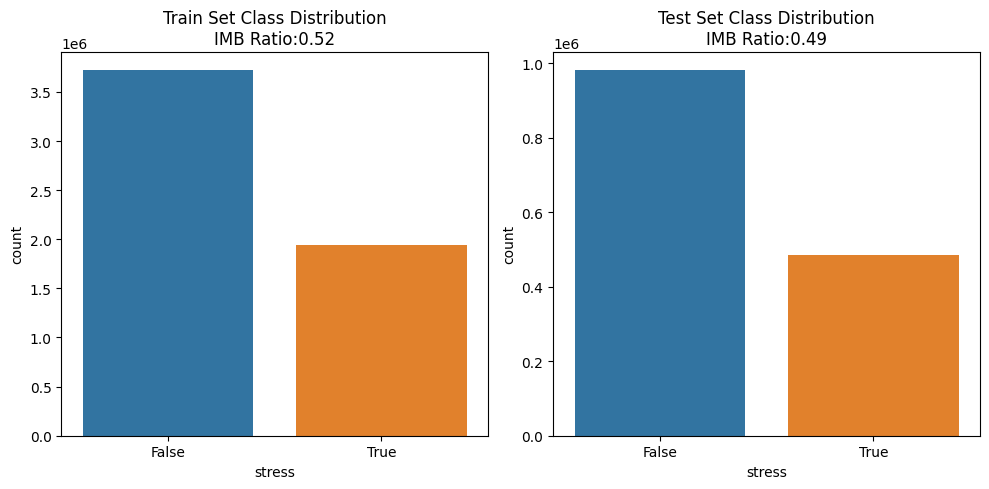

In [19]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_set, x='stress')
_ = plt.title(f"Train Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(train_set)}")

plt.subplot(1, 2, 2)
sns.countplot(data=test_set, x='stress')
_ = plt.title(f"Test Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(test_set)}")

fig.tight_layout(h_pad=0, w_pad=1)

The above graph shows that the split maintains the class distribution of the original set. However, this means that the class imbalance still persist in the splits. My approach to handle this is to trim the leading and trailing non-stress period. More specifically, for each participant, I kept the maximum leading and trailing non-stress period to be `4 mins`.

![experiment-clipping](assets/experiment-clipping.png)

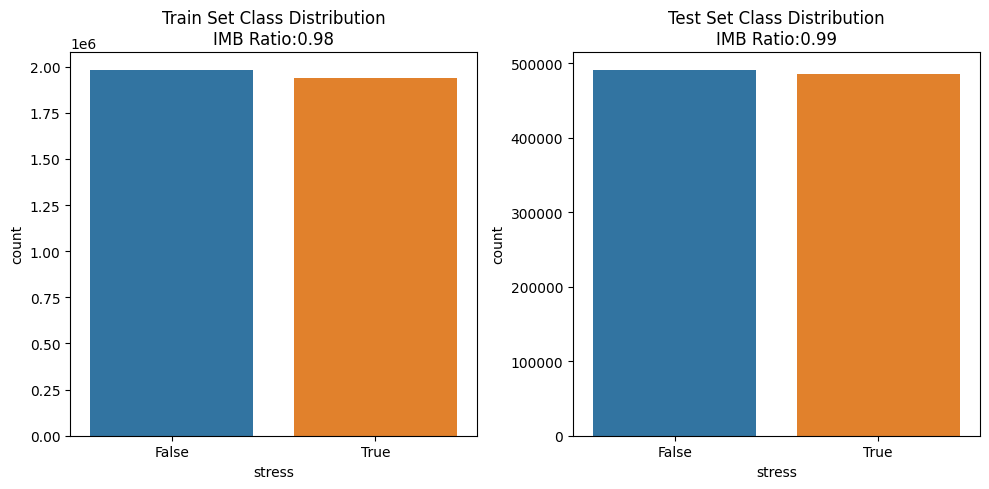

In [20]:
results = []
for participant in train_set['participant'].unique().tolist():
    clipped = utils.clip_participant_experiment_data(train_set[train_set['participant'] == participant])
    results.append(clipped)
    
train_set = pd.concat(results)

results = []
for participant in test_set['participant'].unique().tolist():
    clipped = utils.clip_participant_experiment_data(test_set[test_set['participant'] == participant])
    results.append(clipped)
    
test_set = pd.concat(results)

# plot the new distribution
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_set, x='stress')
_ = plt.title(f"Train Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(train_set)}")

plt.subplot(1, 2, 2)
sns.countplot(data=test_set, x='stress')
_ = plt.title(f"Test Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(test_set)}")

fig.tight_layout(h_pad=0, w_pad=1)

As shown in the above graph, after the trimming process, the class imbalance ratio of the train set and test set is 0.98 and 0.99, respectively.

In [21]:
train_set.to_csv(os.path.join(DATA_DIR, "train.csv"), index=False)
test_set.to_csv(os.path.join(DATA_DIR, "test.csv"), index=False)

# 6. Statistical Modelling <a class="anchor" id="statistical-modelling"></a>

This section performs statistically modelling on the `train/test` splits created in the previous section.

Due to memory constraints, I downsampled my 64Hz train/test split data to 2Hz.

In [15]:
train_set, test_set = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))[::32], pd.read_csv(os.path.join(DATA_DIR, "test.csv"))[::32] # downsample to 2hz

## 6.1. Hyperparameter Tuning & Cross Validation <a class="anchor" id="hyperparameter-tuning-&-cross-validation"></a>

The following code cells run hyperparameter tuning to find the best configuration of parameters and combination of sensors for `DecisionTreeClassifier`. Each configuration undergoes **leave-one-participant-out** cross validation on the training set that consists of 27 participants.

The configruations to try are defined in `param_grid` where the keys are:
- `data__window_size`: The sliding window size.
- `data__stride`: The step size of the sliding window movement.
- `data__features`: The different features to include.
- `clf__criterion`: The `criterion` parameter to use with `DecisionTreeClassifier`.
- `clf__max_depth`: The `max_depth` parameter to use with `DecisionTreeClassifier`.

Additional parameters can be passed into `DecisionTreeClassifier` by adding an extra key in the dictionary (e.g. `clf__splitter`).

In [5]:
output_filepath = os.path.join(OUTPUT_DIR, "dt_cv_results.csv")

In [2]:
param_grid = {
    "data__window_size": [int(2 * i) for i in [5, 10, 20, 40, 60]], # converting seconds to number of samples
    "data__stride": [int(2 * j) for j in [0.5, 1, 1.5, 2, 2.5, 3, 3.5]], # converting seconds to number of samples
    "data__features": utils.get_all_combinations(["ACC", "IBI", "TEMP", "EDA", "HR"]),
    "clf__criterion": ["entropy"],
    "clf__max_depth": [None, 5, 10, 20, 40],
}

In [ ]:
utils.start_hyperparameter_tuning(param_grid, train_set, DecisionTreeClassifier, output_filepath)

The `cv_results` variable contains a DataFrame of results from different configurations on different cross validation splits.

In [8]:
cv_results = pd.read_csv(output_filepath)

# get the mean/std of each configuration across different splits (28 participants -> 1 cv value).
cv_results = cv_results.drop(['split_val', 'split_train', 'tp', 'fp', 'tn', 'fn'], axis=1)\
                    .groupby(list(param_grid.keys()), dropna=False).agg(['mean', 'std'])\
                    .reset_index()

cv_results.columns = ["_".join(c) if c[-1] != "" else c[0] for c in cv_results.columns.to_flat_index()]

cv_results.head(n=5) # first 5 configurations and their cv scores

,data__window_size,data__stride,data__features,clf__criterion,clf__max_depth,accuracy_mean,accuracy_std,recall_score_mean,recall_score_std,precision_score_mean,precision_score_std,f1_score_mean,f1_score_std
0,10,1,"('ACC', 'EDA')",entropy,5.00000,0.60810,0.09601,0.56927,0.21819,0.63327,0.13673,0.57268,0.13895
1,10,1,"('ACC', 'EDA')",entropy,10.00000,0.52888,0.06325,0.51434,0.21105,0.52279,0.07730,0.50058,0.12442
2,10,1,"('ACC', 'EDA')",entropy,20.00000,0.53564,0.04966,0.50513,0.14283,0.53918,0.06374,0.51018,0.07848
3,10,1,"('ACC', 'EDA')",entropy,40.00000,0.53204,0.04885,0.51042,0.13763,0.53328,0.06295,0.51173,0.07646
4,10,1,"('ACC', 'EDA')",entropy,NaN,0.53293,0.05000,0.50574,0.13706,0.53480,0.06642,0.51000,0.07751


## 6.2. Testing <a class="anchor" id="testing"></a>

From the above `5425` configurations, I trained the best configuration for each sensor combinations and evaluate their peroformance on the test set. Each configurations is tested 10 times to get the means and standard deviations of the evaluations.

In [ ]:
mask = cv_results.groupby(['data__features'], dropna=False)['f1_score_mean'].transform(max) == cv_results['f1_score_mean']
best_config = cv_results.loc[mask].reset_index(drop=True)[list(param_grid.keys())]
best_config = best_config.loc[best_config.index.repeat(10)] # repeat the testing process for same configuration 10 times

test_results = []

for idx, params in tqdm(list(best_config.iterrows()), desc="Tests"):
    params = params.to_dict()
    params['data__features'] = ast.literal_eval(params['data__features'])
    data_params = {
            k.split("__")[-1]: v for k, v in params.items() if k.split("__")[0] == "data"}
    clf_params = {
        k.split("__")[-1]: v for k, v in params.items() if k.split("__")[0] == "clf"}
    clf_params['max_depth'] = int(clf_params['max_depth']) if not np.isnan(clf_params['max_depth']) else None
    
    train = train_set.drop(['timestamp', 'participant'], axis=1)
    test = test_set.drop(['timestamp', 'participant'], axis=1)
    
    X_train, y_train = utils.preprocess(
        train.drop(['stress'], axis=1),
        train['stress'],
        **data_params
    )
    
    X_test, y_test = utils.preprocess(
        test.drop(['stress'], axis=1),
        test['stress'],
        **data_params
    )

    clf = DecisionTreeClassifier(**clf_params) # random_state default is None
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc, precision, recall, f1, tn, fp, fn, tp = utils.evaluate(y_test, y_pred)

    evaluations = {
        "accuracy": acc,
        "recall_score": recall,
        "precision_score": precision,
        "f1_score": f1,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    }

    test_results.append(dict(params, **evaluations))

pd.DataFrame(test_results).to_csv(os.path.join(OUTPUT_DIR, f"dt_test_results_best_config_by_features.csv"), index=False)

# 7. Results Analysis and Discussion <a class="anchor" id="results-analysis-and-discussion"></a>

This sections analyses the results on test sets from the previous section.

## 7.1. Effects of Sensors Combination <a class="anchor" id="effects-of-sensors-combination"></a>

In [23]:
def row_formatter(x):
    evaluation_results = [f"{round(x[i] * 100, 2)} (±{round(x[i+1]*100, 2)})" for i in range(5, len(x), 2)]
    params = list(x[:5])
    params[2] = "+".join(ast.literal_eval(params[2])) # convert tuple of sensors combination to format sensorA+sensorB
    params[4] = int(params[4]) # convert max_depth to int
    return params + evaluation_results

result = utils.read_test_result(os.path.join(OUTPUT_DIR, "dt_test_results_best_config_by_features.csv"), param_grid=param_grid)
result = result.sort_values(by=['f1_score_mean'], ascending=False)\
    .head(n=10)\
    .apply(row_formatter, axis=1, result_type="expand")\
    .rename(columns={0: "window_size", 1: "stride", 2: "features", 3: 'criterion', 4: 'max_depth', 5: 'accuracy', 6: 'recall', 7: 'precision', 8: 'f1_score'})\
    .reset_index(drop=True)

result.to_csv(os.path.join(OUTPUT_DIR, "top-10-models.csv"), index=False)
result

,window_size,stride,features,criterion,max_depth,accuracy,recall,precision,f1_score
0,120,2,IBI+HR,entropy,5,52.21 (±0.0),85.91 (±0.0),51.29 (±0.0),64.23 (±0.0)
1,80,4,IBI+TEMP+HR,entropy,5,55.91 (±0.0),78.63 (±0.0),53.98 (±0.0),64.01 (±0.0)
2,80,4,TEMP+HR,entropy,5,55.55 (±0.0),74.17 (±0.0),53.94 (±0.0),62.46 (±0.0)
3,20,4,EDA+HR,entropy,5,52.14 (±0.0),78.52 (±0.0),51.25 (±0.0),62.02 (±0.0)
4,20,4,IBI+EDA+HR,entropy,5,52.21 (±0.0),77.02 (±0.0),51.32 (±0.0),61.6 (±0.0)
5,80,2,IBI,entropy,5,52.53 (±0.0),73.23 (±0.0),51.7 (±0.0),60.61 (±0.0)
6,40,7,IBI+TEMP+EDA,entropy,10,56.17 (±0.05),67.24 (±0.04),54.89 (±0.05),60.44 (±0.03)
7,40,7,TEMP+EDA,entropy,10,55.88 (±0.09),66.57 (±0.0),54.69 (±0.08),60.05 (±0.05)
8,40,7,EDA,entropy,5,54.96 (±0.0),66.99 (±0.0),53.84 (±0.0),59.7 (±0.0)
9,40,2,ACC+IBI+EDA,entropy,5,60.19 (±0.0),58.23 (±0.0),60.41 (±0.0),59.3 (±0.0)


The above table shows that `IBI+HR` yields the best score on the test set. In fact, among the top 10 combinations, only the 10th combination utilises `ACC`. This result aligns with other study that suggests that biological features are more suitable for predicting stress.

To visualise this, we can examine the below box plot. It shows the performance comparison between models that include a certain sensors versus with out that sensor.

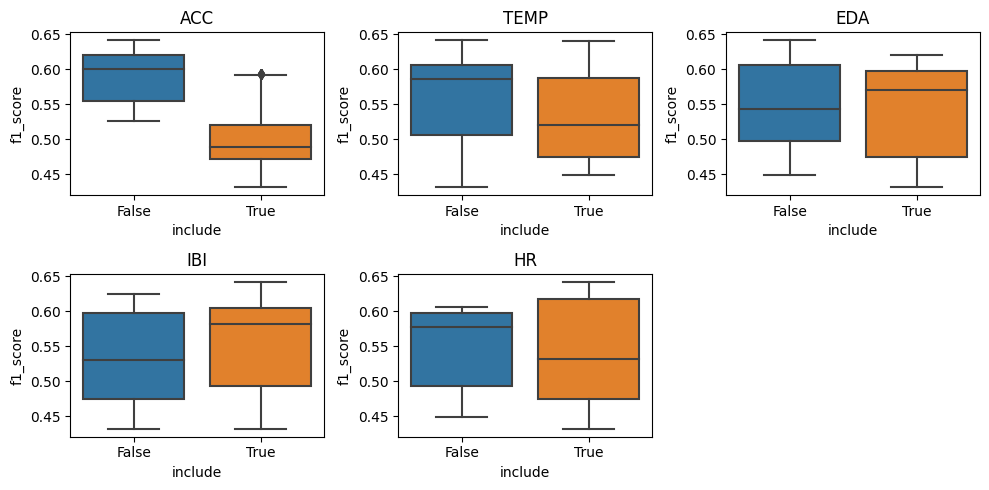

In [15]:
temp = pd.read_csv(os.path.join(OUTPUT_DIR, "dt_test_results_best_config_by_features.csv"))

fig = plt.figure(figsize=(10, 5))

sensors = ["ACC", "TEMP", "EDA", "IBI", "HR"]

for idx, sensor in enumerate(sensors):
    plt.subplot(2, 3, 1 + idx)
    t = temp.copy()
    t[f'include_sensor_{sensor}'] = t['data__features'].apply(lambda x: sensor in ast.literal_eval(x))
    sns.boxplot(data=t, x=f'include_sensor_{sensor}', y='f1_score')
    plt.xlabel('include')
    plt.ylabel('f1_score')
    plt.title(f"{sensor}")

fig.tight_layout(h_pad=1, w_pad=1)
# plt.suptitle("Inclusion of Sensor", y=1.05)
plt.show()

Let examine further the importance of the remaining sensors: `IBI, TEMP, EDA, and HR`

In [3]:
result = utils.read_test_result(os.path.join(OUTPUT_DIR, "dt_test_results_best_config_by_features.csv"), param_grid=param_grid)
result['num_sensors'] = result['data__features'].apply(lambda x: len(ast.literal_eval(x)))
result = result.sort_values(by=['num_sensors', 'f1_score_mean'], ascending=False)\
        .drop(['data__window_size', 'data__stride', 'clf__criterion', 'clf__max_depth', 'num_sensors'], axis=1)\
        .apply(lambda x: ["+".join(ast.literal_eval(x[0]))] + [f"{round(x[i] * 100, 2)} (±{round(x[i+1]*100, 2)})" for i in range(1, len(x[1:]), 2)], axis=1, result_type="expand")\
        .reset_index(drop=True)\
        .rename(columns={0: "sensors", 1: "accuracy", 2: "recall", 3: "precision", 4: "f1"})
result.to_csv(os.path.join(OUTPUT_DIR, "test-results-of-sensor-combination.csv"), index=False)
result

,sensors,accuracy,recall,precision,f1
0,ACC+IBI+TEMP+EDA+HR,56.94 (±0.0),39.23 (±0.0),60.35 (±0.0),47.55 (±0.0)
1,IBI+TEMP+EDA+HR,56.01 (±0.61),52.13 (±1.32),56.38 (±0.6),54.17 (±0.93)
2,ACC+IBI+TEMP+HR,53.11 (±0.96),46.48 (±1.49),53.33 (±1.09),49.66 (±1.26)
3,ACC+IBI+TEMP+EDA,56.89 (±0.0),42.03 (±0.0),59.53 (±0.0),49.27 (±0.0)
4,ACC+TEMP+EDA+HR,56.94 (±0.0),39.23 (±0.0),60.35 (±0.0),47.55 (±0.0)
5,ACC+IBI+EDA+HR,53.15 (±0.0),35.75 (±0.0),54.39 (±0.0),43.14 (±0.0)
6,IBI+TEMP+HR,55.91 (±0.0),78.63 (±0.0),53.98 (±0.0),64.01 (±0.0)
7,IBI+EDA+HR,52.21 (±0.0),77.02 (±0.0),51.32 (±0.0),61.6 (±0.0)
8,IBI+TEMP+EDA,56.17 (±0.05),67.24 (±0.04),54.89 (±0.05),60.44 (±0.03)
9,ACC+IBI+EDA,60.19 (±0.0),58.23 (±0.0),60.41 (±0.0),59.3 (±0.0)


There are two interesting characteristics from the above table:
1. The features from `IBI` provide the best result with `EDA` as second when used individually. However, models that combines these two sensors `IBI+EDA` perform worst. This suggests that features from the two sensors are correlated. This same effect is also present between the `TEMP` and `IBI` sensor.

2. The `HR` sensor although does not yeild good result individually, significantly improves the score when added to `IBI, TEMP, and EDA`.

These results suggest that features from `IBI + HR` are the most useful for predicting stress.

Let's further examine the feature importance of the best performing model.

In [16]:
train = train_set.drop(['timestamp', 'participant'], axis=1)

X_train, y_train = utils.preprocess(
    train.drop(['stress'], axis=1),
    train['stress'].copy(),
    window_size=120,
    stride=2,
    features=('IBI', 'HR')
)

clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

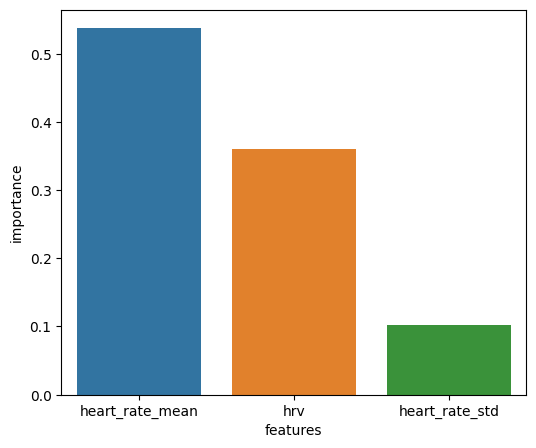

In [17]:
importances = pd.Series(clf.feature_importances_, index=X_train.columns.tolist())
importances = importances.sort_values(ascending=False)
importances = pd.DataFrame({
    "features": importances.index,
    "importance": importances.values
})

fig = plt.figure(figsize=(6, 5))

_ = sns.barplot(data=importances, x='features', y='importance')
# _ = plt.title("Feature Importance")

The above figure shows that `heart_rate_mean` has the most impact on the decision of the model with `hrv` coming in second. We can further example how the model uses these features to make decision.

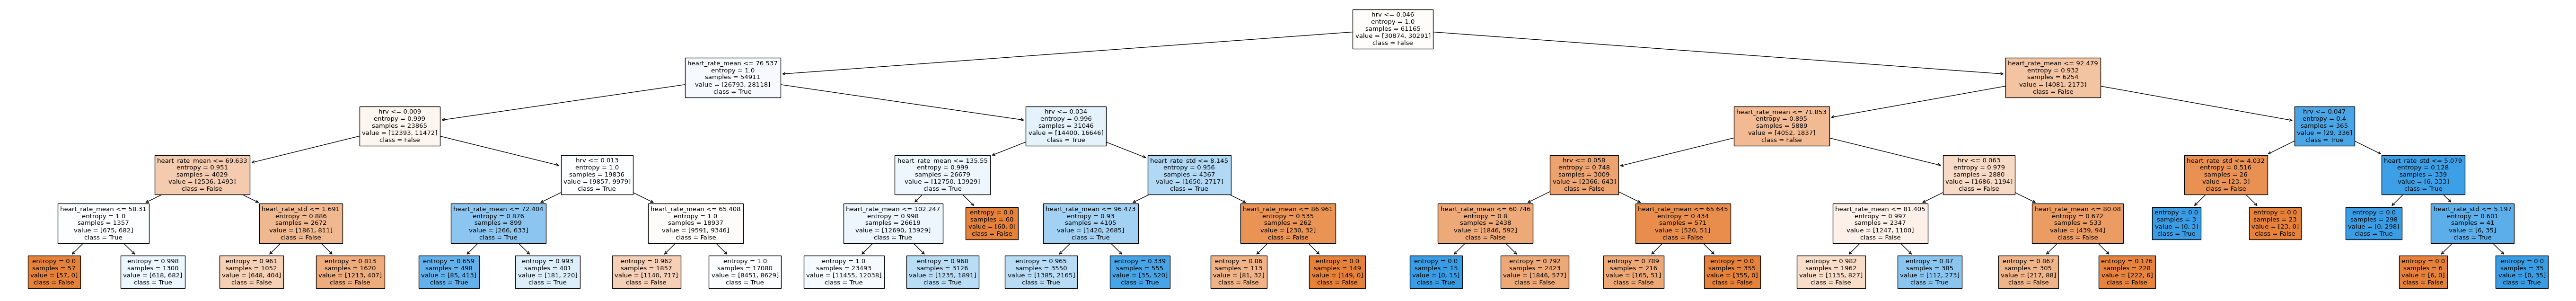

In [58]:
fig = plt.figure(figsize=(70,8))
_ = plot_tree(
    clf,
    feature_names=X_train.columns.tolist(),
    filled=True,
    class_names=[str(i) for i in clf.classes_]
)

The above tree shows that the model can easily distinguish between stress and non stress samples when `hrv > 0.046` and `heart_rate_mean > 92.479` because its terminal nodes only consists of samples from one class. Furthermore, the majority of the terminal nodes in that branch belongs to the `stress=True` class. This signals that when people are stress their heart rate is high and the gap between their consective heart beats becomes larger. This phenomenon persist but is less clear cut when `hrv <= 0.046` and `heart_rate_mean > 76.537`

## 7.2. Effects of Window Sizes and Strides <a class="anchor" id="effects-of-window-sizes-and-strides"></a>

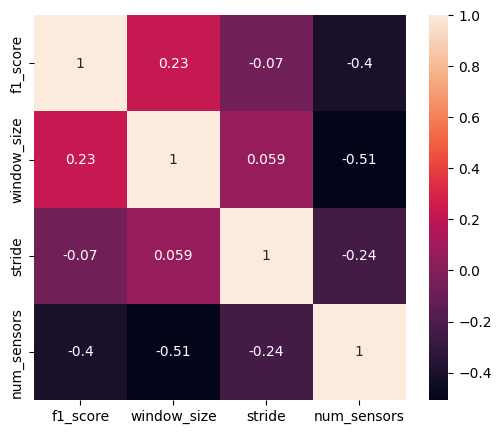

In [14]:
temp = pd.read_csv(os.path.join(OUTPUT_DIR, "dt_test_results_best_config_by_features.csv"))
temp['num_sensors'] = temp['data__features'].apply(lambda x: len(ast.literal_eval(x)))
temp = temp[['f1_score', 'data__window_size', 'data__stride', 'num_sensors']]
temp = temp.rename(columns={
    "data__window_size": "window_size",
    "data__stride": "stride"
})

fig = plt.figure(figsize=(6, 5))
_ = sns.heatmap(temp.corr(), annot=True)
# plt.title("Data Parameters Correlation with F1 Score", y=1.05)

Interestingly, `window_size` does have a positive correlation with `f1_score`. A reason behind this would be that a larger window size provide the model with more previous information to learn from. On the other hand, there seems to be an inverse but negible correlation between `f1_score` and `stride`. That can be attributed to how the effects of `stride` depends on the `window_size`. A small stride with a large window size retains a lot of information while a small stride with small window size decreases the amount of information. Furthermore, looking at the `number_sensors`, we can see that it has negative correlations with both `window_size` and `stride`. This suggests that when more features are added increasing the window size makes it harder for the model to learn. It can also suggests that when more features are added, more fine grain aggregation of the time series is needed.

The above shows that it is better to use a configuration that retains large amount of information. That is using a large window size and small stride.

# 8. Final Model Training <a class="anchor" id="final-model-training"></a>

This code section is used to train a final model that includes both data from both the train and test split. The trained model can be used for final inference.

In [27]:
MODEL_NAME = "final_model"
WINDOW_SIZE = 120
STRIDE = 2
SAMPLING_RATE = 2

output_dir = os.path.join(OUTPUT_DIR, MODEL_NAME)

data = pd.concat([train_set, test_set])\
        .drop(['timestamp', 'participant'], axis=1)

X, y = utils.preprocess(
    data.drop(['stress'], axis=1),
    data['stress'].copy(),
    window_size=WINDOW_SIZE,
    stride=STRIDE,
)

clf = DecisionTreeClassifier(
    max_depth=5,
    criterion='entropy',
    random_state=0,
)

clf.fit(X, y)

os.makedirs(output_dir, exist_ok=True)

# save model file
pickle.dump(clf, open(os.path.join(output_dir, f"model.pkl"), 'wb'))

# save config file for determining the window size and stride to use
with open(os.path.join(output_dir, f'model.json'), 'w') as jsonfile:
    jsonfile.write(json.dumps({
        "window_size": WINDOW_SIZE,
        "stride": STRIDE,
        "sampling_rate": SAMPLING_RATE,
    }))